# Obtención y merjoramiento de la imagen

## carga de archivos


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import math
import os
import pandas as pd
import SimpleITK as sitk
from sklearn.cluster import KMeans


In [65]:
#from google.colab import drive
#drive.mount('/content/drive')


In [66]:

# aca pongan el path a su carpeta de imagenes del drive
test_image_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/test/images'

train_image_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/train/images'
train_labels_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/train/labels'
# me armo una lista
test_image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

train_image_files = [f for f in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, f))]
train_labels_files = [f for f in os.listdir(train_labels_dir) if os.path.isfile(os.path.join(train_labels_dir, f))]
# creo un dataframe con las rutas de las imagenes
test_image_paths = pd.DataFrame({'ImagePath': [os.path.join(test_image_dir, f) for f in test_image_files]})

train_image_paths = pd.DataFrame({'ImagePath': [os.path.join(train_image_dir, f) for f in train_image_files]})
train_labels_paths = pd.DataFrame({'LabelPath': [os.path.join(train_labels_dir, f) for f in train_labels_files]})
print(len(test_image_paths))
print(len(train_image_paths))
print(len(train_labels_paths))

123
1054
1054


In [67]:
# creo un vector vacio para guardar las imagenes
test_images = []
train_images = []
train_labels = []   
# en cada valor guardo una imagen
for path in test_image_paths['ImagePath']:
    # leo en grices
    img = cv2.imread(path, 0)
    test_images.append(img)
for path in train_image_paths['ImagePath']:
    # leo en grices
    img = cv2.imread(path, 0)
    train_images.append(img)
# cantidad de imagenes cargadas
#cargo las labels 
for path in train_labels_paths['LabelPath']:
    # leo los labels
    with open(path, 'r') as file:
        lines = file.read().splitlines()
        separated_values = [line.split() for line in lines]
        # Convierto los valores a float y aplano la lista
        numeric_values = [float(value) for line in separated_values for value in line]
    train_labels.append(numeric_values)

La lista "labels" contiene informacion sobre las dimensiones de las bounding box de cada calculo renal


In [68]:
print(f"Cantidad total de imagenes de testeo: {len(test_images)}")

print(f"Cantidad total de imagenes de entrenamiento: {len(train_images)}")

print(f"Cantidad total de labels de entrenamiento: {len(train_labels)}")

Cantidad total de imagenes de testeo: 123
Cantidad total de imagenes de entrenamiento: 1054
Cantidad total de labels de entrenamiento: 1054


In [69]:
print(train_labels[0][1])

0.3312020460358056


## Lectura de archivos

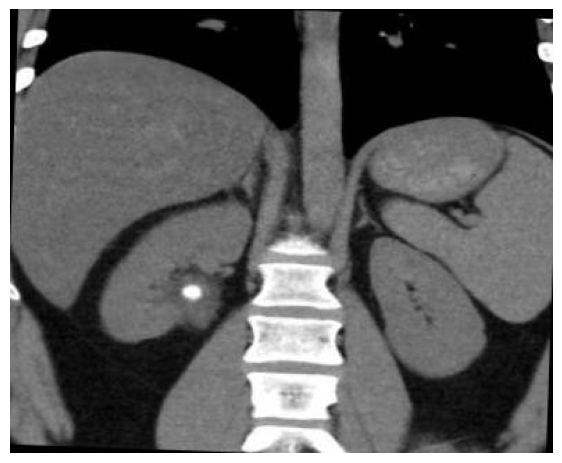

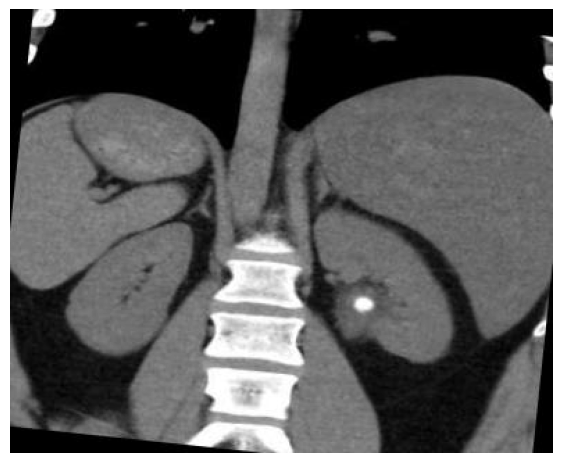

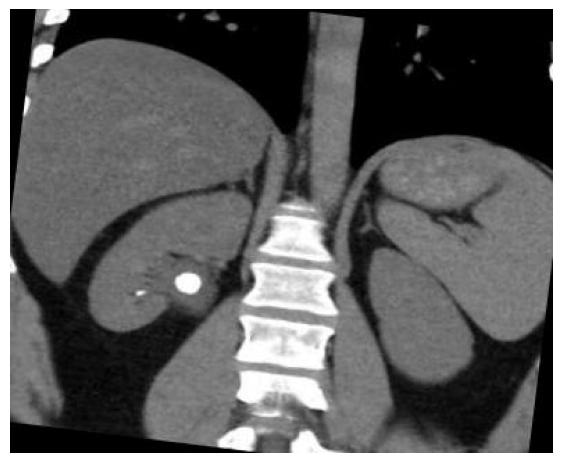

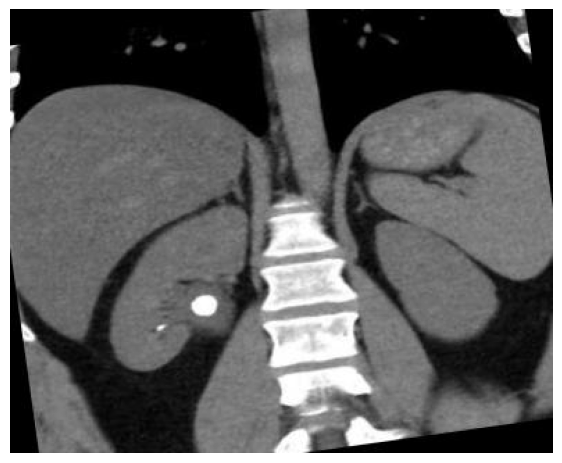

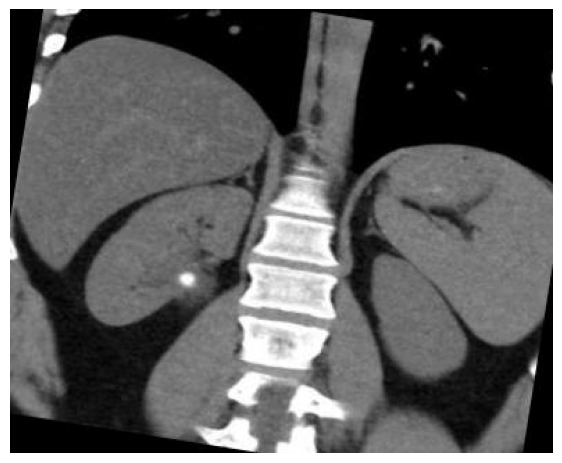

In [70]:
for i in range(0, 5):
    plt.figure(figsize=(7,7))
    plt.imshow(train_images[i], cmap="gray",vmin=0, vmax=255)
    plt.axis(False)
    plt.show()

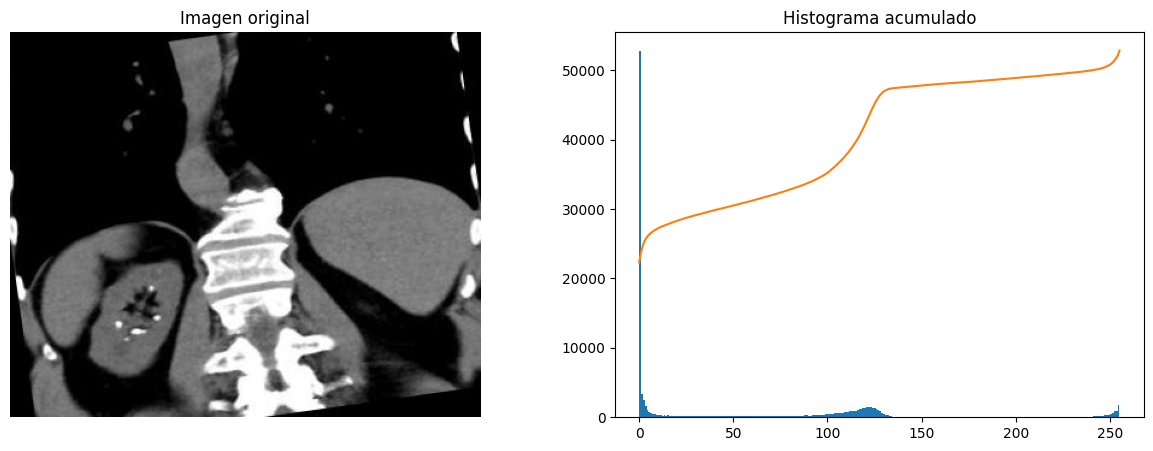

In [71]:
#Generamos histograma

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()


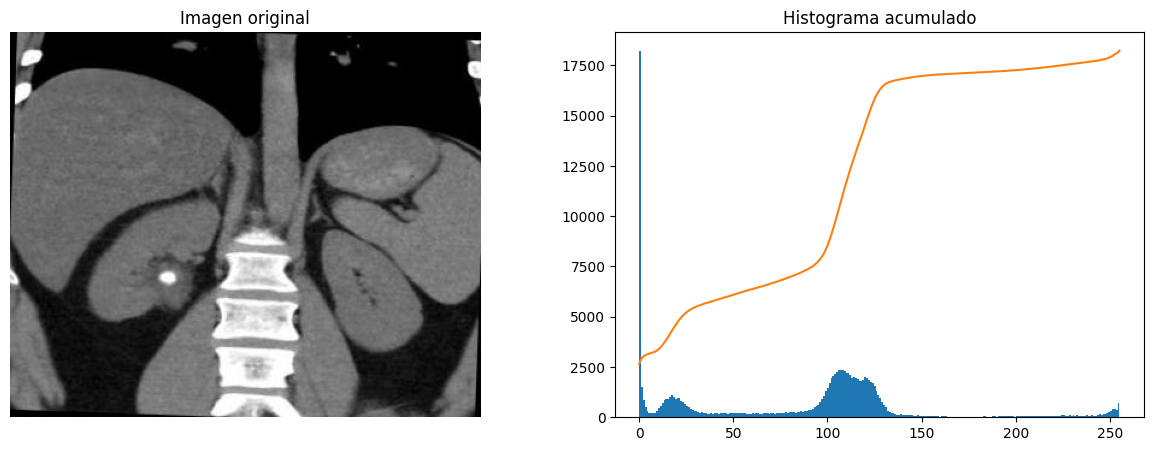

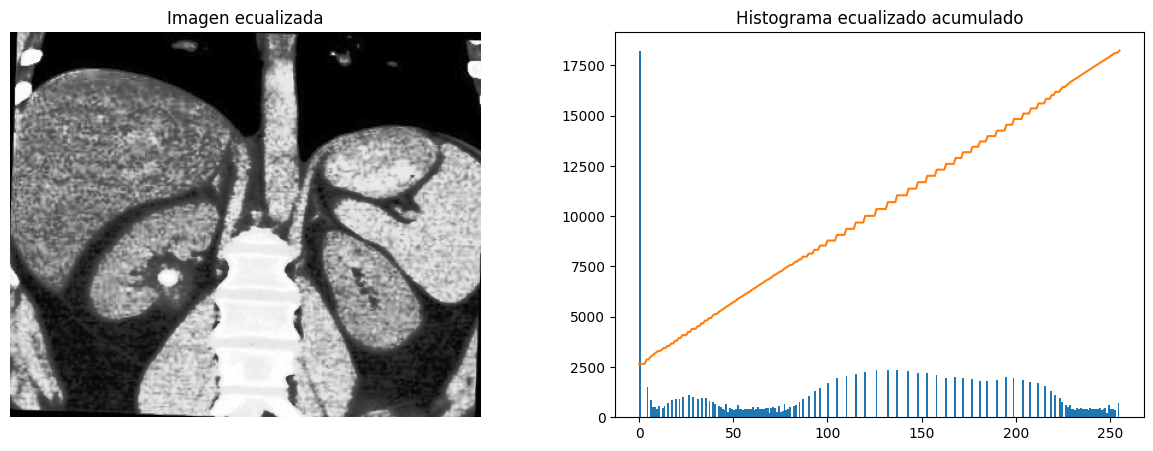

In [72]:
#Ecualizamos
img = train_images[0]
img_ec = cv2.equalizeHist(img)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()

hist,bins = np.histogram(img_ec.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img_ec,vmin=0, vmax=255,cmap='gray')
ax[0].set_title('Imagen ecualizada')
ax[0].axis(False)
ax[1].hist(np.ravel(img_ec), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma ecualizado acumulado")
plt.show()

## Binarizacion

Para encontrar el calculo y poder segmentarlo, primeramente hay que **binarizar la imagen**. Para ello, conviene aplicar alguno de los metodos de umbralizado, como Otsu. Sin embargo, este último actua mejor sobre histogramas bimodales, por lo que la ecualización de la imagen no es útil en este caso.

110.0


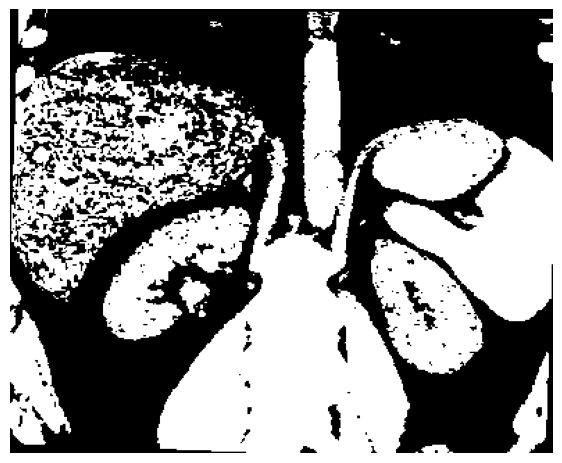

In [73]:
umbral, img_otsu = cv2.threshold(img_ec, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(umbral)
plt.figure(figsize=(7,7))
plt.imshow(img_otsu, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

Vemos que por *Otsu* el resultado no es óptimo, dado que el histograma no es bimodal y hay presencia de grices cercanos a la región de interés. Por ende, no conviene realizar la binarización por este método. Lo ideal para sacar las regiones de gris cercanas al cálculo renal es clusterizarlas y binarizar luego.

In [74]:
def kmeans(imagen,k, iteraciones,epsilon):
  copia=imagen.copy()
  pixel_vals = copia.reshape((-1))#se pasa la dimensión de la imagen a no--> NO IMPORTA LA DISTRIBUCIÓN ESPACIAL
  pixel_vals = np.float32(pixel_vals)#El algoritmos nos pide floats de 32 bits
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iteraciones, epsilon) #se para el algoritmo cuando se haya cumplido el epsilon o cuando se hayan acabado las iteraciones,cada attemp itera n veces, epsilon (precision)

  flags = cv2.KMEANS_RANDOM_CENTERS #situa los centroides inicales

  compactness, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, flags)

  center = np.uint8(centers)

  img_1_kmeans = center[labels.flatten()] #Asigna a cada píxel el valor del centro del cluster al que pertenece
  img_1_kmeans = img_1_kmeans.reshape((copia.shape))
  centers=centers.flatten()
  return img_1_kmeans, centers



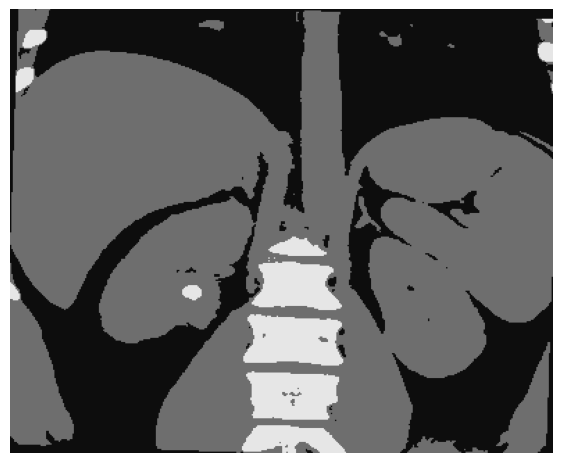

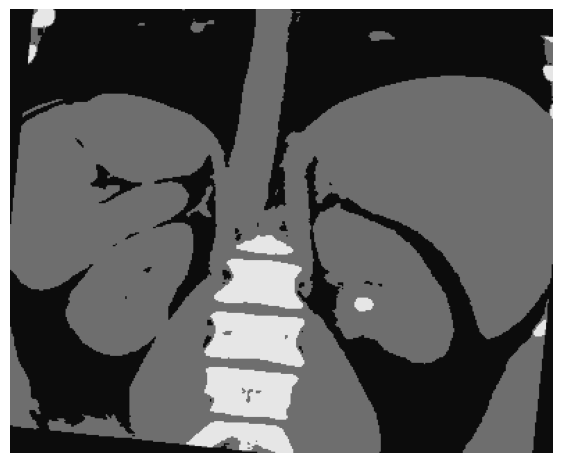

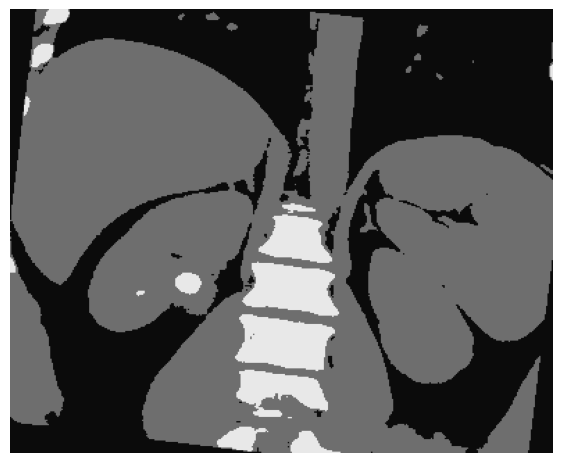

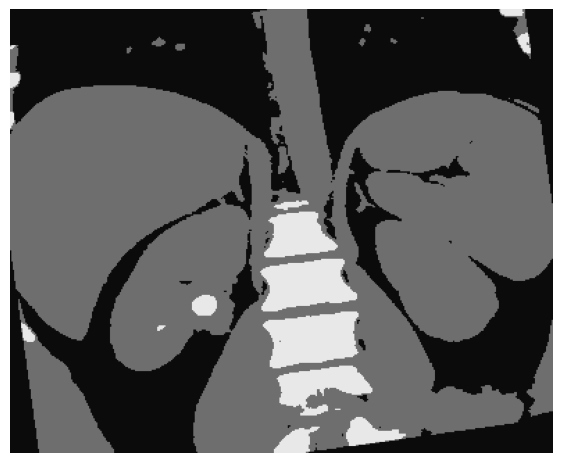

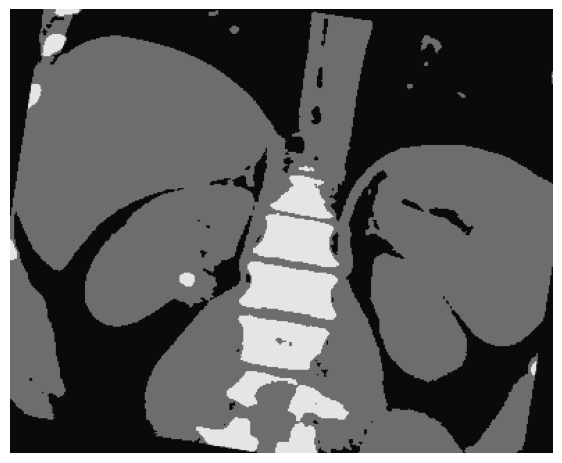

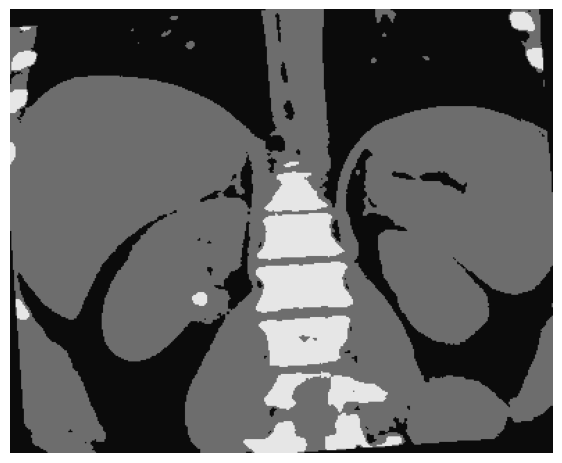

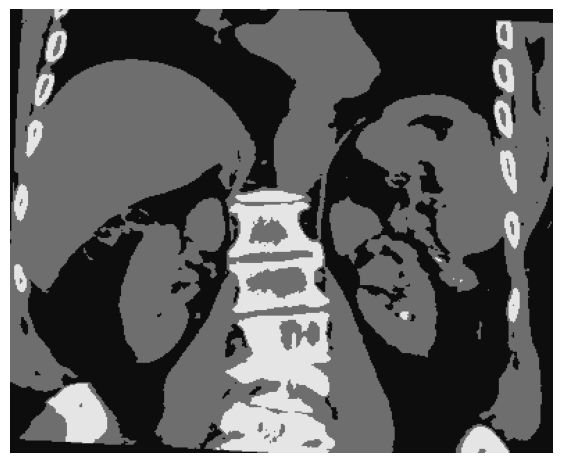

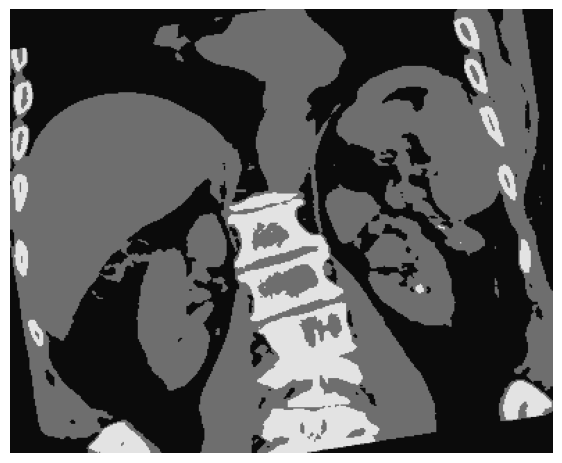

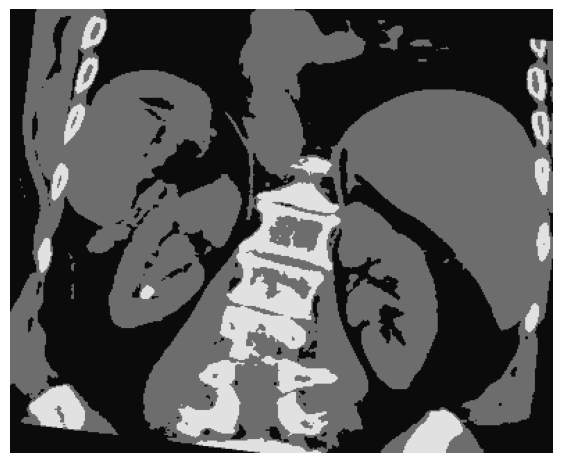

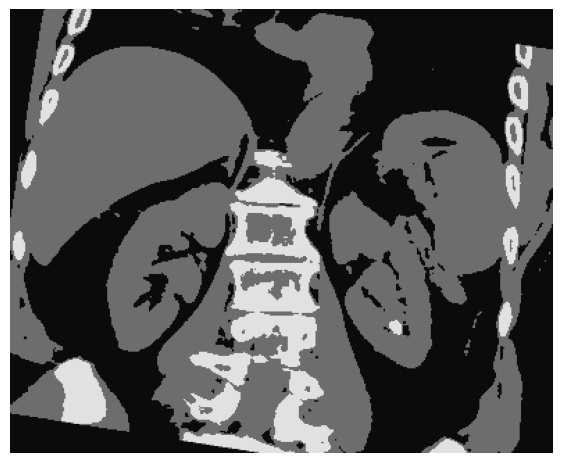

In [75]:
for i in range(0, 10):
  img=train_images[i]
  img_kmeans,_=kmeans(img,3,10,0.9)
  plt.figure(figsize=(7,7))
  plt.imshow(img_kmeans, cmap="gray",vmin=0, vmax=255)
  plt.axis(False)
  plt.show()

[230.40236   12.200597 110.15541 ]


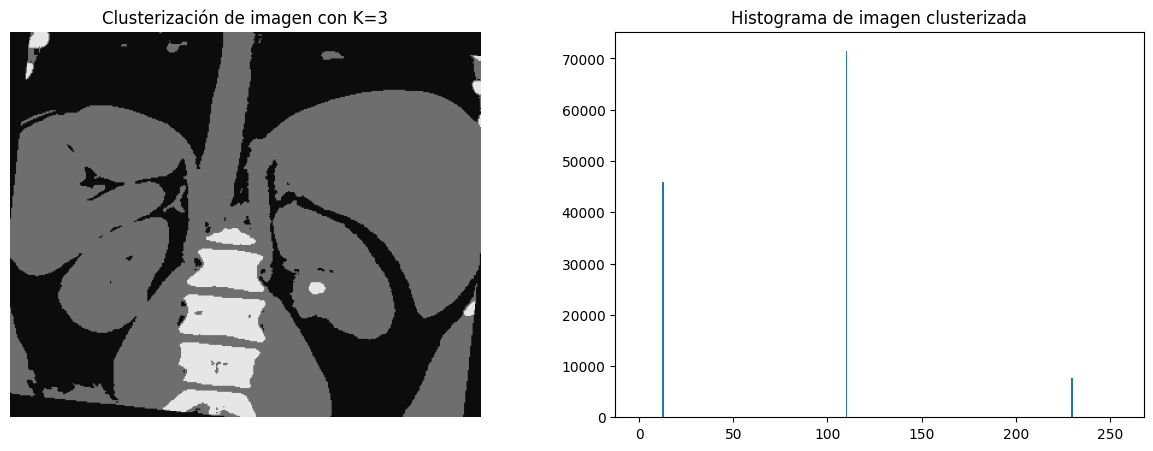

In [76]:
img=train_images[1]
img_cluster, centros=kmeans(img,3,10,0.9)
fig,ax = plt.subplots(1,2,figsize=(15,5))
print(centros)

ax[0].imshow(img_cluster, cmap="gray",vmin=0, vmax=255)
ax[0].set_title("Clusterización de imagen con K=3")
ax[0].axis(False)
ax[1].hist(np.ravel(img_cluster), bins=256, range=(0,255))
ax[1].set_title("Histograma de imagen clusterizada")
plt.show()

In [77]:
def binarizar(img_clust, centros):
  umb, img_bin = cv2.threshold(img_clust, max(centros)-10, 255, cv2.THRESH_BINARY)
  return umb, img_bin

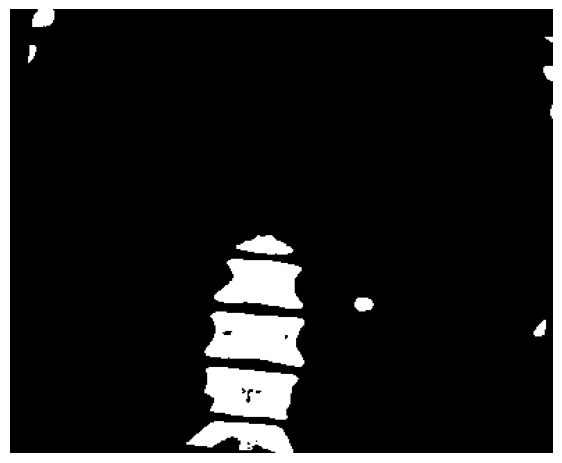

In [78]:
imgbin=binarizar(img_cluster,centros)[1]
plt.figure(figsize=(7,7))
plt.imshow(imgbin, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

In [79]:
ret, labels = cv2.connectedComponents(imgbin)#ret es la cantidad de etiquetas y labels la matriz de la imagen etiquetada
ret


13

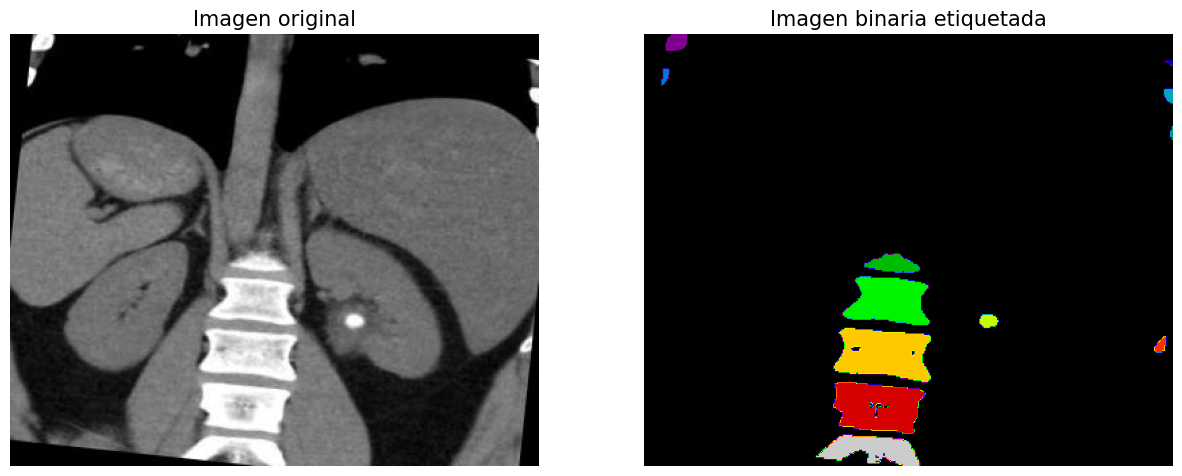

In [80]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Imagen original',fontsize=15)
plt.axis(False)
plt.subplot(122)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Imagen binaria etiquetada',fontsize=15)
plt.axis(False)
plt.show()

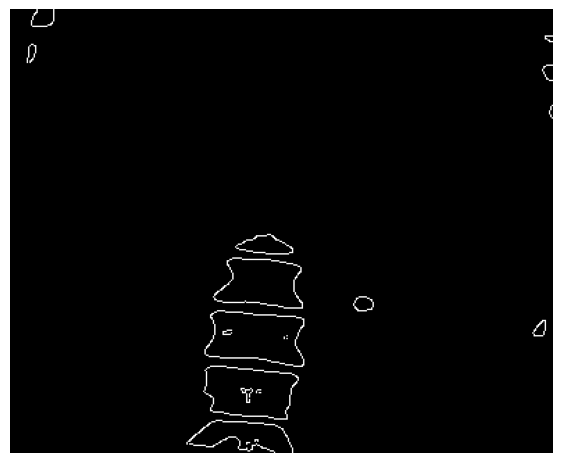

In [81]:
img_Canny = cv2.Canny(imgbin, 200, 256)
plt.figure(figsize=(7,7))
plt.imshow(img_Canny, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

## Bounding Boxes

In [82]:
def analisis_cajas(labels):
    Areas = []
    Ratios = []
    Coordenadas = []
    Dimensiones = []
    for i in range(len(labels)):
        if len(labels[i])>4:
            for j in range(1,len(labels[i]),5):
                x = labels[i][j]*391
                y = labels[i][j+1]*320
                w = labels[i][j+2]*391
                h = labels[i][j+3]*320
                ratio = w/h
                Ratios.append(ratio)
                Areas.append(w*h)
                Coordenadas.append([x,y])
                Dimensiones.append([w,h])
    return Areas, Ratios, Coordenadas, Dimensiones
def promedios_cajas(Areas, Ratios):
    prom_area = np.mean(Areas)
    prom_ratio = np.mean(Ratios)
    desv_area = np.std(Areas)
    desv_ratio = np.std(Ratios)
    return prom_area,desv_area, prom_ratio, desv_ratio

In [83]:
Areas, Ratios, _,_ = analisis_cajas(train_labels)
Prom_A, Desv_A,Prom_R,Desv_R = promedios_cajas(Areas, Ratios)
print(f"El promedio de las áreas de las cajas es: {Prom_A}")
print(f"La desviación estándar de las áreas de las cajas es: {Desv_A}")
print(f"El promedio de los ratios de las cajas es: {Prom_R}")
print(f"La desviación estándar de los ratios de las cajas es: {Desv_R}")

El promedio de las áreas de las cajas es: 332.9258121158911
La desviación estándar de las áreas de las cajas es: 1012.2164109212516
El promedio de los ratios de las cajas es: 1.2405585080204762
La desviación estándar de los ratios de las cajas es: 0.36949181738229714


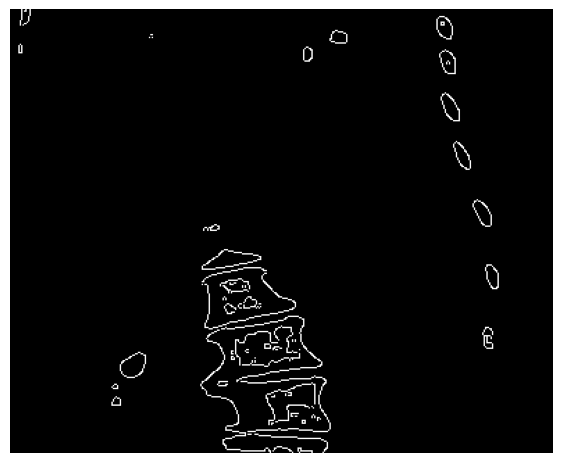

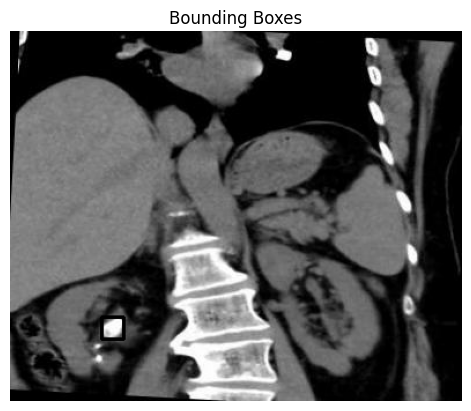

In [84]:
Areas, Ratios, coordendas,dimensiones = analisis_cajas(train_labels)
Prom_A, Desv_A,Prom_R,Desv_R = promedios_cajas(Areas, Ratios)
img = train_images[150]
img_cluster, centros=kmeans(img,3,10,0.9)
imgbin=binarizar(img_cluster,centros)[1]
img_Canny = cv2.Canny(imgbin, 200, 256)
plt.figure(figsize=(7,7))
plt.imshow(img_Canny, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()
# Find contours
contours, _ = cv2.findContours(img_Canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)    
    # Comparar el área del contorno con el promedio y desviación estándar calculados
    if .5*Prom_A < w*h < 1.5*Prom_A and Prom_R - Desv_R < w/h < Prom_R + Desv_R:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Mostrar el resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Bounding Boxes')
plt.axis('off')
plt.show()

Creo una funcion que contenga todo el proceso para ser mas ordenado

Esta bien, marcamos las bounding boxes y claramente toma el calculo. Pero, como nos deshacemos del resto de cajas. El primer aproach va a ser generar valores promedios que nos permitan determinar si se trata de un calculo o no

In [85]:
def Boxes(img,Prom_A,Desv_A,Prom_R,Desv_R,Cota):
    img_cluster, centros=kmeans(img,3,10,0.9)
    imgbin=binarizar(img_cluster,centros)[1]
    img_Canny = cv2.Canny(imgbin, 200, 256)
    contours, _ = cv2.findContours(img_Canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if Prom_A*(1-Cota) < w*h < Prom_A*(1+Cota) and Prom_R - Desv_R < w/h < Prom_R + Desv_R:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Bounding Boxes')
    plt.axis('off')
    plt.show()

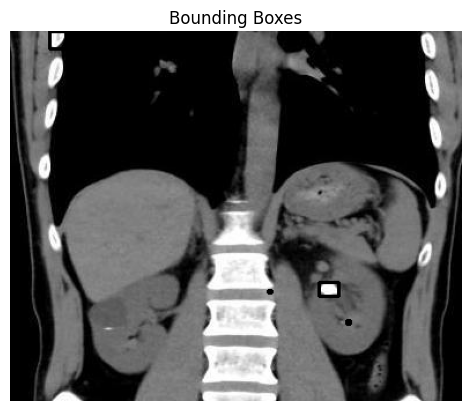

In [91]:
Boxes(test_images[100],Prom_A,Desv_A,Prom_R,Desv_R,2)

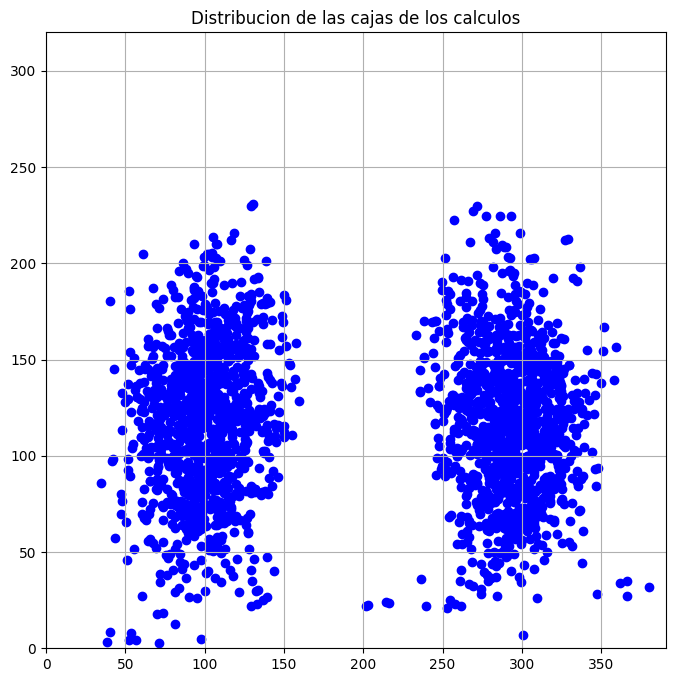

In [87]:
# Extract x and y coordinates from Coordenadas
x_coords = [coord[0] for coord in coordendas]
y_coords = [(321-coord[1]) for coord in coordendas]

# Create a scatter plotI want to fit on a real
plt.figure(figsize=(8, 8))
plt.xlim(0, 391)
plt.ylim(0, 320)
plt.scatter(x_coords, y_coords, c='blue', marker='o')
plt.title('Distribucion de las cajas de los calculos')
plt.grid(True)
plt.show()

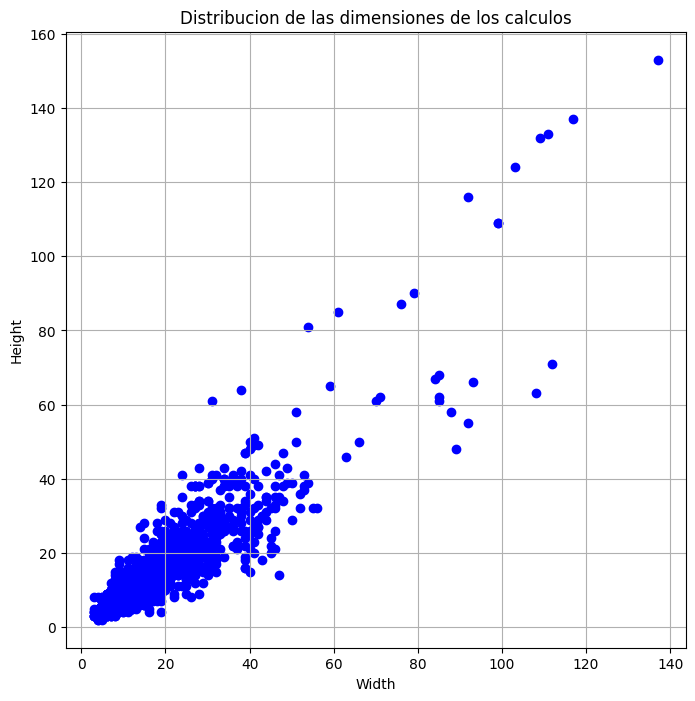

In [88]:
# Extract width and height from Dimensiones
widths = [dim[0] for dim in dimensiones]
heights = [dim[1] for dim in dimensiones]

# Create a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, c='blue', marker='o')
plt.title('Distribucion de las dimensiones de los calculos')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()

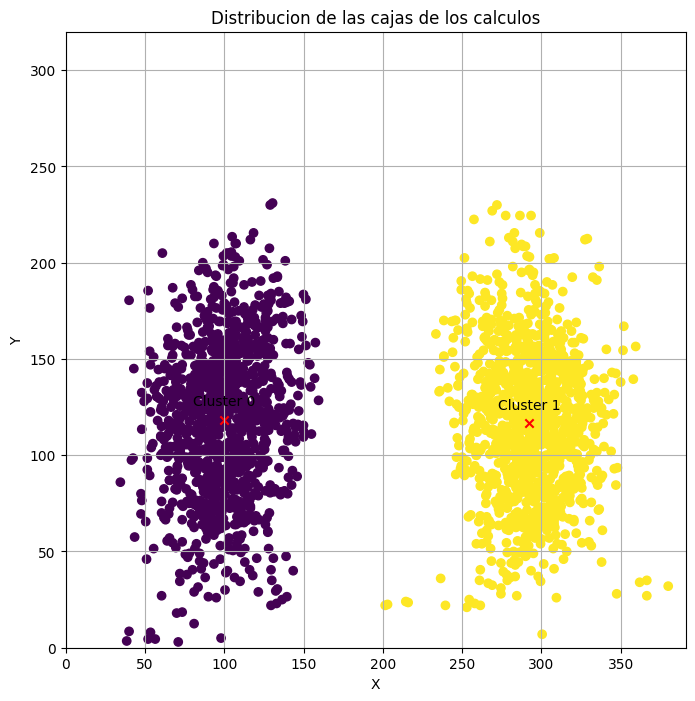

In [89]:
k_pos = KMeans(n_clusters=2)
clusters = k_pos.fit_predict(np.column_stack((x_coords, y_coords)))
centroid = k_pos.cluster_centers_

plt.figure(figsize=(8, 8))
plt.xlim(0, 391)
plt.ylim(0, 320)
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(x_coords, y_coords, c=clusters, marker='o')
plt.scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x')  # Plot centroids

# Annotate the centroids
for i, center in enumerate(centroid):
    plt.annotate(f'Cluster {i}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Distribucion de las cajas de los calculos')
plt.grid(True)
plt.show()


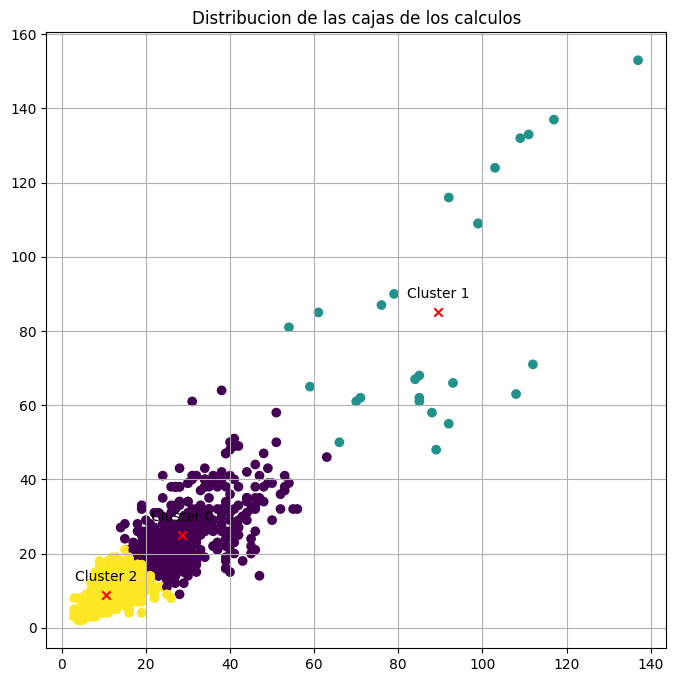

In [90]:
k_dim = KMeans(n_clusters=3)
clusters = k_dim.fit_predict(np.column_stack((widths, heights)))
centroid = k_dim.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, c=clusters, marker='o')
plt.scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x')  # Plot centroids

# Annotate the centroids
for i, center in enumerate(centroid):
    plt.annotate(f'Cluster {i}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Distribucion de las cajas de los calculos')
plt.grid(True)
plt.show()